## 12-30-2025

# Module 1: Quality Control & Filtering

**Purpose:**
- Assess data quality from BAM files
- Check bisulfite conversion efficiency  
- Evaluate batch effects on QC metrics
- Define filtering criteria for downstream analysis

**Inputs:**
- `data/processed/sample_manifest.csv` (from Module 0)
- BAM files

**Outputs:**
- `data/processed/qc_metrics.csv`
- `results/qc_report.txt`
- QC plots in `results/figures/qc/`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import Module 1 functions
from src.qc import (
    calculate_bam_stats,
    check_bisulfite_conversion,
    run_qc_on_all_samples,
    assess_batch_effects,
    generate_qc_plots,
    generate_qc_report,
    run_module_1
)

# Import config
from src.config import SAMPLE_MANIFEST, QC_METRICS, QC_REPORT, QC_FIGURES_DIR

## Option 1: Quick Run - Execute Complete Module 1

Run all QC steps at once:

In [2]:
# Run complete Module 1 pipeline
qc_metrics, batch_effects = run_module_1()


MODULE 1: Quality Control & Filtering

Loading sample manifest from: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/processed/sample_manifest.csv
✓ Loaded manifest: 22 samples

Calculating QC metrics for all samples...


Processing samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:08<00:00,  2.65it/s]



✓ QC metrics calculated for 22 samples

Assessing batch effects on QC metrics...

Batch Effect Assessment:
               metric  discovery_mean  validation_mean  difference  p_value significant
          total_reads   127240.000000    127052.571429 -187.428571 0.763949          No
           mapped_pct      100.000000       100.000000    0.000000 1.000000          No
  properly_paired_pct      100.000000       100.000000    0.000000 1.000000          No
       duplicate_rate        0.000000         0.000000    0.000000 1.000000          No
            mean_mapq       38.343101        38.305242   -0.037859 0.441136          No
   mean_fragment_size      179.906123       168.281900  -11.624223 0.006367         Yes
conversion_efficiency        0.995142         0.993526   -0.001616 0.238240          No
 cpg_methylation_rate        0.656934         0.635784   -0.021150 0.024017         Yes

2/8 metrics show significant batch effects (p < 0.05)

Generating QC plots...
  ✓ Saved: qc_metrics

### Examine QC Metrics

Let's look at the results:

In [3]:
# Display QC metrics
print(f"QC metrics shape: {qc_metrics.shape}")
print(f"\nColumns: {list(qc_metrics.columns)}")

# Display first few rows
qc_metrics.head()

QC metrics shape: (22, 27)

Columns: ['sample_id', 'disease_status', 'batch', 'age', 'total_reads', 'mapped_reads', 'mapped_pct', 'properly_paired', 'properly_paired_pct', 'duplicates', 'duplicate_rate', 'mean_mapq', 'fragment_count', 'mean_fragment_size', 'median_fragment_size', 'std_fragment_size', 'min_fragment_size', 'max_fragment_size', 'reads_sampled', 'reads_with_xm', 'total_chh_sites', 'total_cpg_sites', 'chh_methylation_rate', 'conversion_efficiency', 'cpg_methylation_rate', 'conversion_flag', 'conversion_pct']


,sample_id,disease_status,batch,age,total_reads,mapped_reads,mapped_pct,properly_paired,properly_paired_pct,duplicates,...,max_fragment_size,reads_sampled,reads_with_xm,total_chh_sites,total_cpg_sites,chh_methylation_rate,conversion_efficiency,cpg_methylation_rate,conversion_flag,conversion_pct
0,SRR13404367,als,discovery,61,128966,128966,100.0,128966,100.0,0,...,983,10000,10000,104357,8222,0.004791,0.995209,0.671005,PASS,99.520875
1,SRR13404368,als,discovery,57,129002,129002,100.0,129002,100.0,0,...,1000,10000,10000,99911,7296,0.006266,0.993734,0.683525,PASS,99.373442
2,SRR13404369,als,discovery,85,128158,128158,100.0,128158,100.0,0,...,995,10000,10000,99565,7729,0.005514,0.994486,0.652866,PASS,99.448601
3,SRR13404370,als,discovery,63,125118,125118,100.0,125118,100.0,0,...,984,10000,10000,109682,8622,0.004732,0.995268,0.631872,PASS,99.526814
4,SRR13404371,ctrl,discovery,60,126020,126020,100.0,126020,100.0,0,...,999,10000,10000,101462,7629,0.004553,0.995447,0.638485,PASS,99.544657


In [4]:
# Summary statistics for key metrics
key_metrics = [
    'mean_mapq', 
    'mapped_pct', 
    'properly_paired_pct',
    'duplicate_rate',
    'mean_fragment_size',
    'conversion_efficiency',
    'cpg_methylation_rate'
]

qc_metrics[key_metrics].describe()

,mean_mapq,mapped_pct,properly_paired_pct,duplicate_rate,mean_fragment_size,conversion_efficiency,cpg_methylation_rate
count,22.000000,22.0,22.0,22.0,22.000000,22.000000,22.000000
mean,38.319009,100.0,100.0,0.0,172.508890,0.994114,0.643475
std,0.107506,0.0,0.0,0.0,11.148595,0.005190,0.023014
min,38.124312,100.0,100.0,0.0,161.219704,0.974808,0.608673
25%,38.259959,100.0,100.0,0.0,165.987604,0.994667,0.627917
50%,38.308414,100.0,100.0,0.0,169.214603,0.995648,0.638324
75%,38.372766,100.0,100.0,0.0,173.603588,0.996254,0.666956
max,38.513635,100.0,100.0,0.0,206.298381,0.996915,0.683525


In [5]:
# Flag samples with poor conversion
poor_conversion = qc_metrics[qc_metrics['conversion_efficiency'] < 0.99]

print(f"Samples with conversion < 99%: {len(poor_conversion)}")

if len(poor_conversion) > 0:
    print("\nSamples flagged:")
    print(poor_conversion[['sample_id', 'conversion_efficiency', 'chh_methylation_rate']])
else:
    print("✓ All samples passed conversion threshold!")

Samples with conversion < 99%: 2

Samples flagged:
      sample_id  conversion_efficiency  chh_methylation_rate
13  SRR13404380               0.974808              0.025192
16  SRR13404383               0.982819              0.017181


### Batch Effect Assessment

Check if technical metrics differ between Discovery and Validation batches:

In [6]:
# Display batch effect results
print("Batch Effect Assessment:")
print("=" * 70)
print(batch_effects.to_string(index=False))

# Count significant batch effects
n_sig = (batch_effects['p_value'] < 0.05).sum()
print(f"\n{n_sig}/{len(batch_effects)} metrics show significant batch effects")

if n_sig > 0:
    print("\nMetrics with significant batch effects:")
    sig = batch_effects[batch_effects['p_value'] < 0.05]
    print(sig[['metric', 'p_value', 'discovery_mean', 'validation_mean']])

Batch Effect Assessment:
               metric  discovery_mean  validation_mean  difference  p_value significant
          total_reads   127240.000000    127052.571429 -187.428571 0.763949          No
           mapped_pct      100.000000       100.000000    0.000000 1.000000          No
  properly_paired_pct      100.000000       100.000000    0.000000 1.000000          No
       duplicate_rate        0.000000         0.000000    0.000000 1.000000          No
            mean_mapq       38.343101        38.305242   -0.037859 0.441136          No
   mean_fragment_size      179.906123       168.281900  -11.624223 0.006367         Yes
conversion_efficiency        0.995142         0.993526   -0.001616 0.238240          No
 cpg_methylation_rate        0.656934         0.635784   -0.021150 0.024017         Yes

2/8 metrics show significant batch effects

Metrics with significant batch effects:
                 metric   p_value  discovery_mean  validation_mean
5    mean_fragment_size  0.0063

### View QC Plots

Let's look at the generated plots:

Generated 3 QC plots:
  - conversion_efficiency.png
  - fragment_size_distribution.png
  - qc_metrics_disease_and_batch.png

conversion_efficiency.png


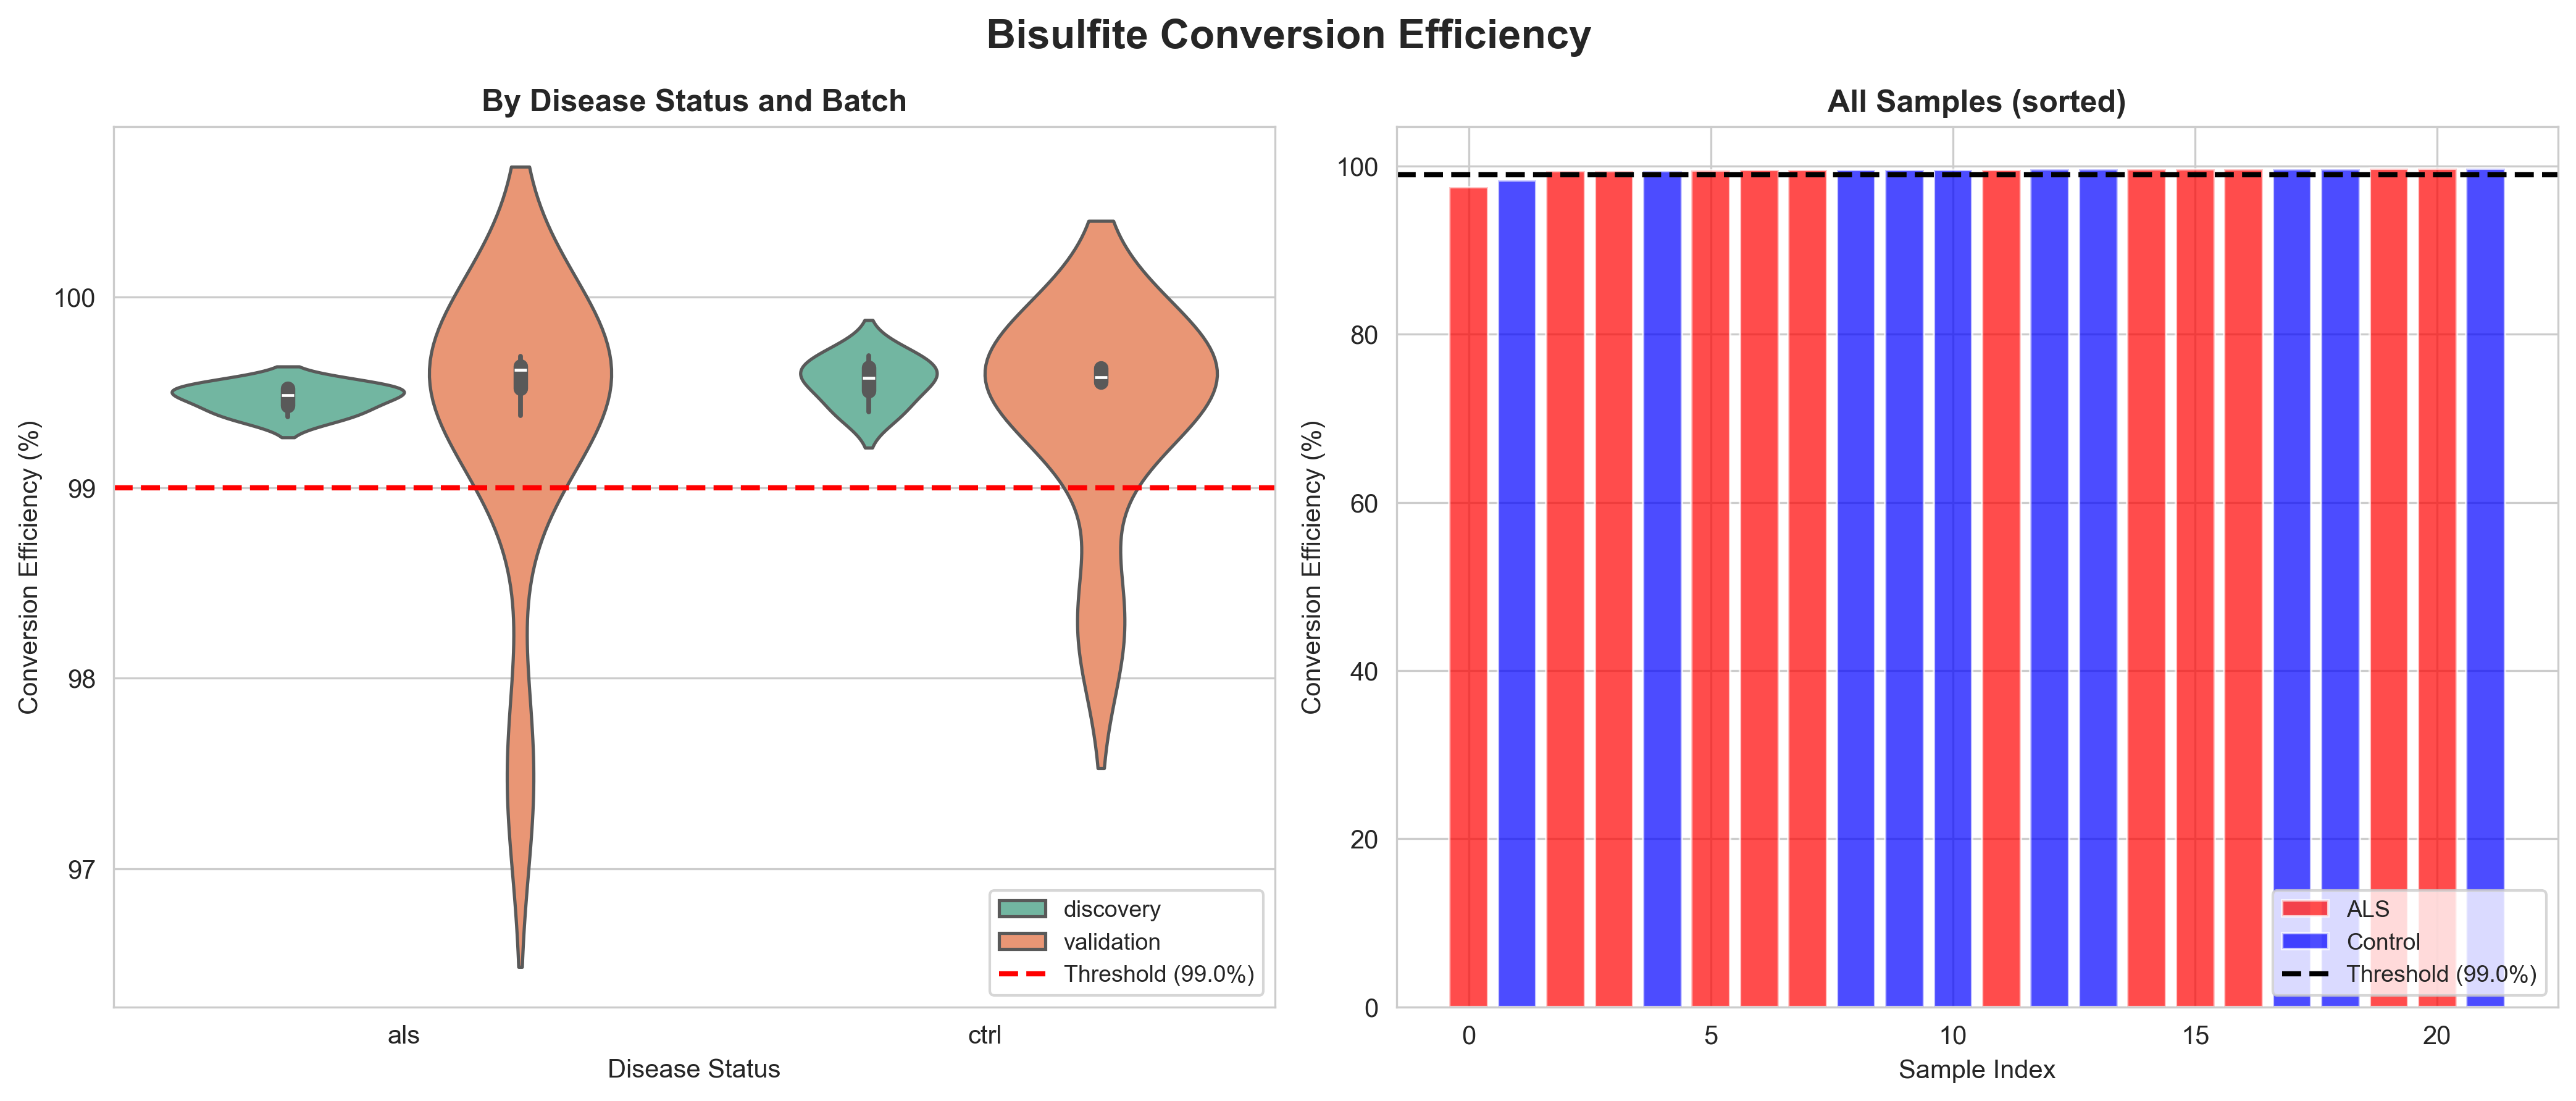


fragment_size_distribution.png


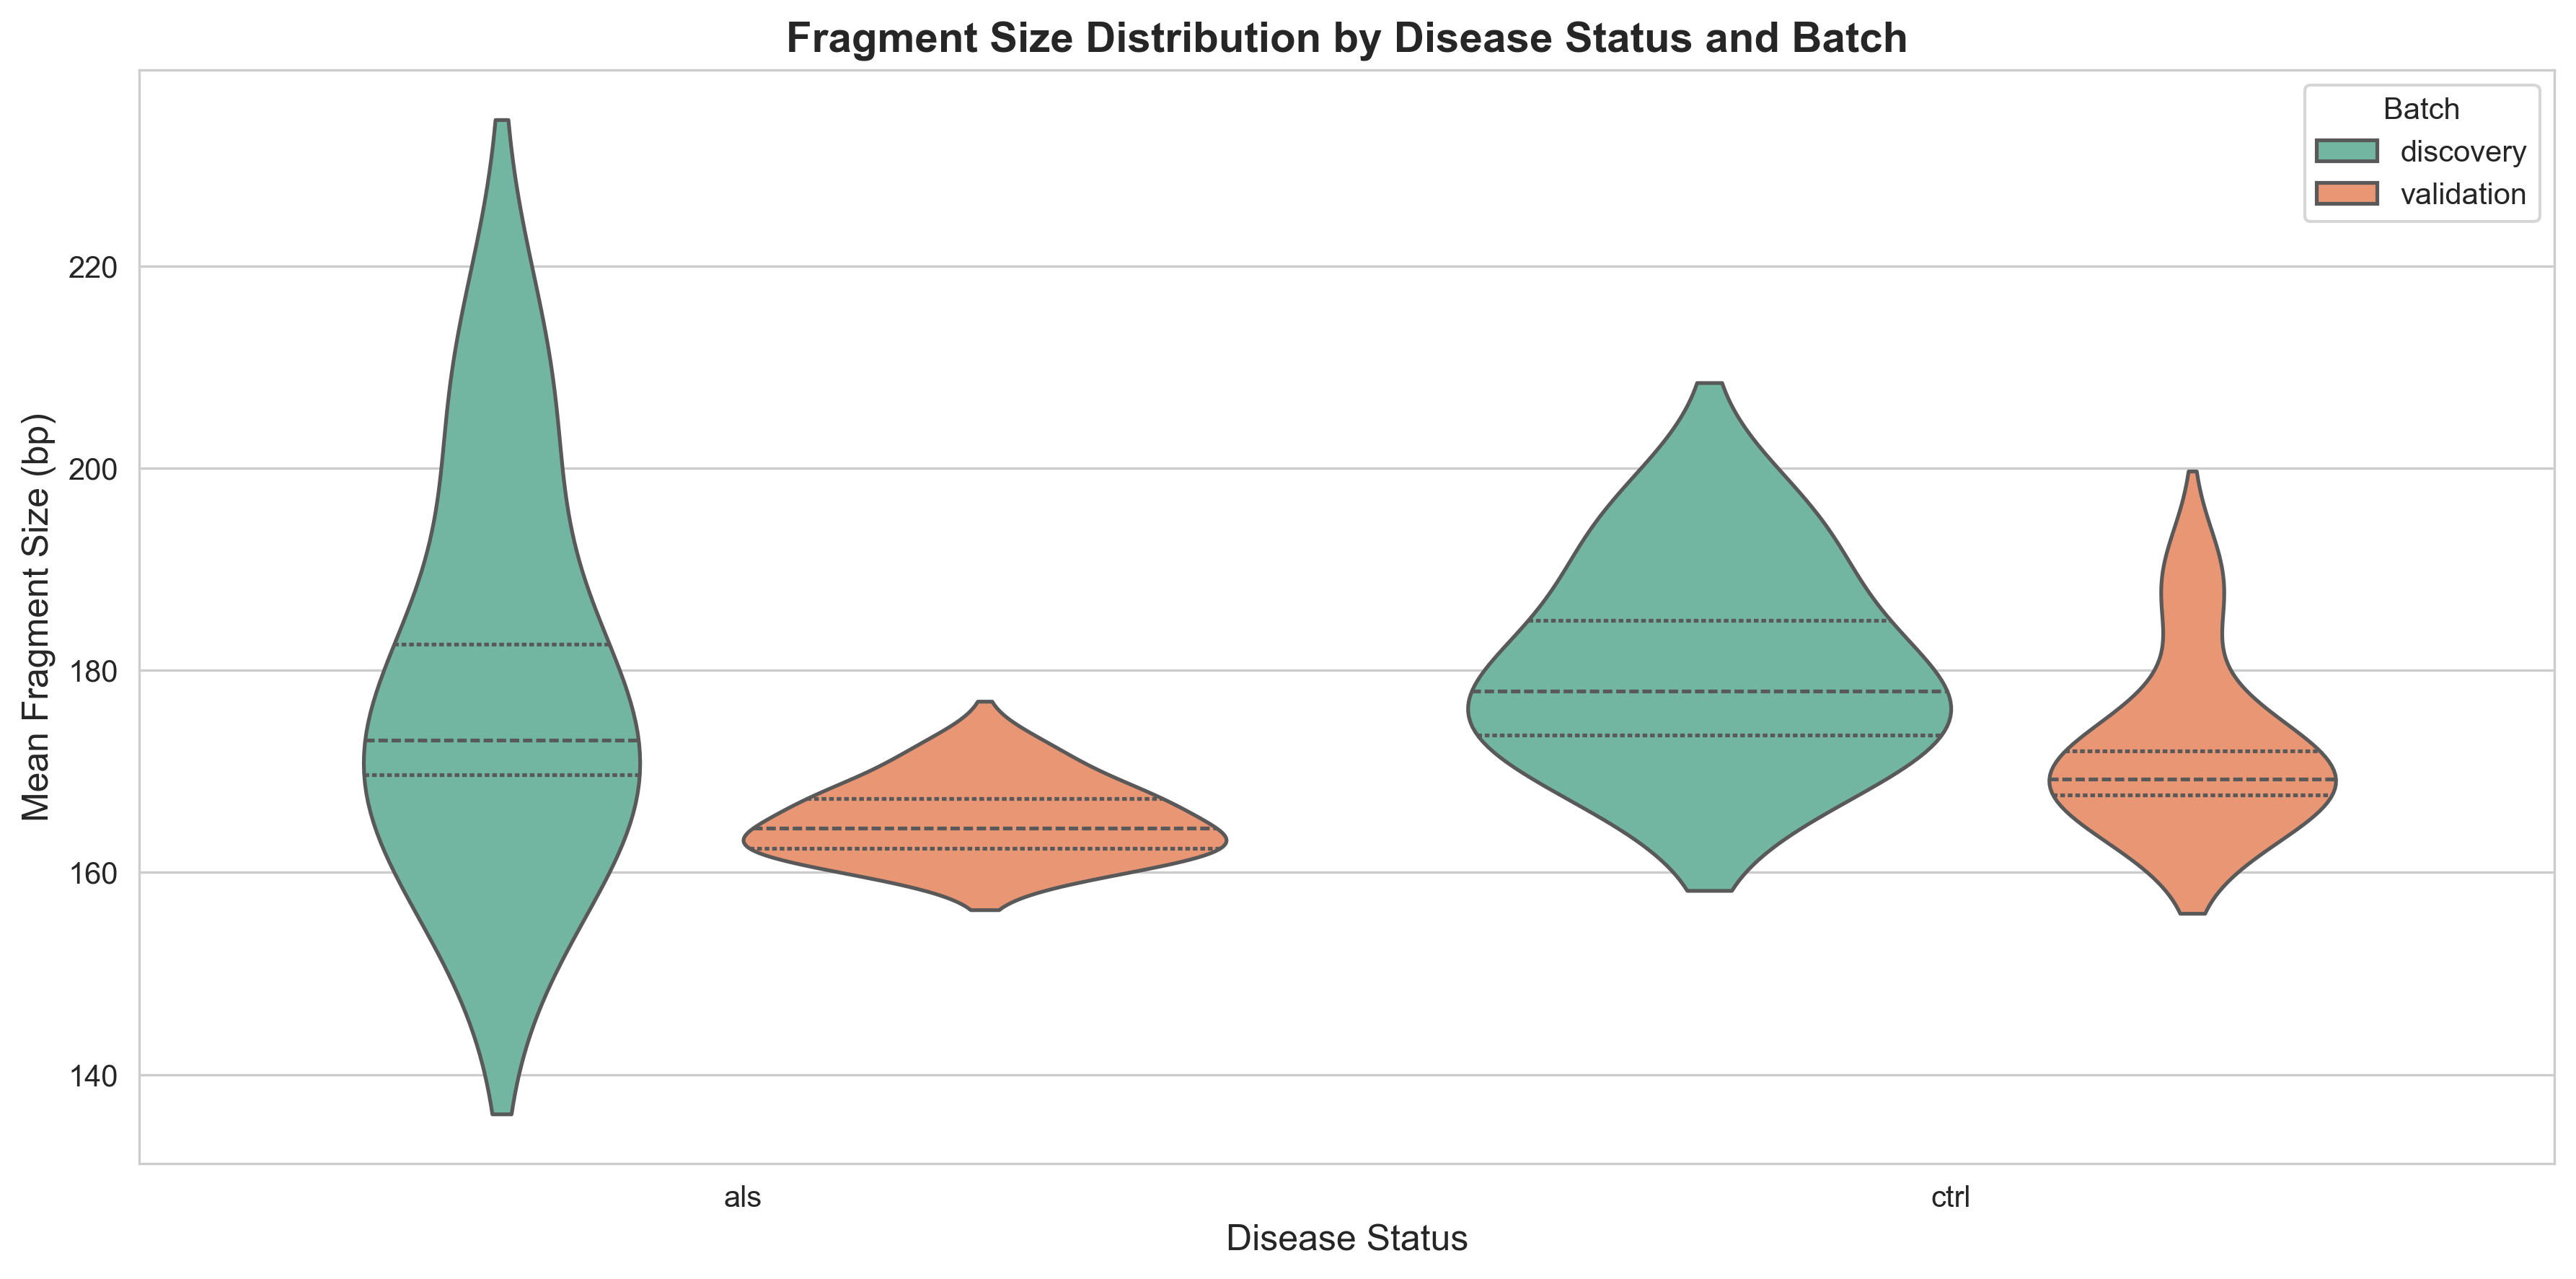


qc_metrics_disease_and_batch.png


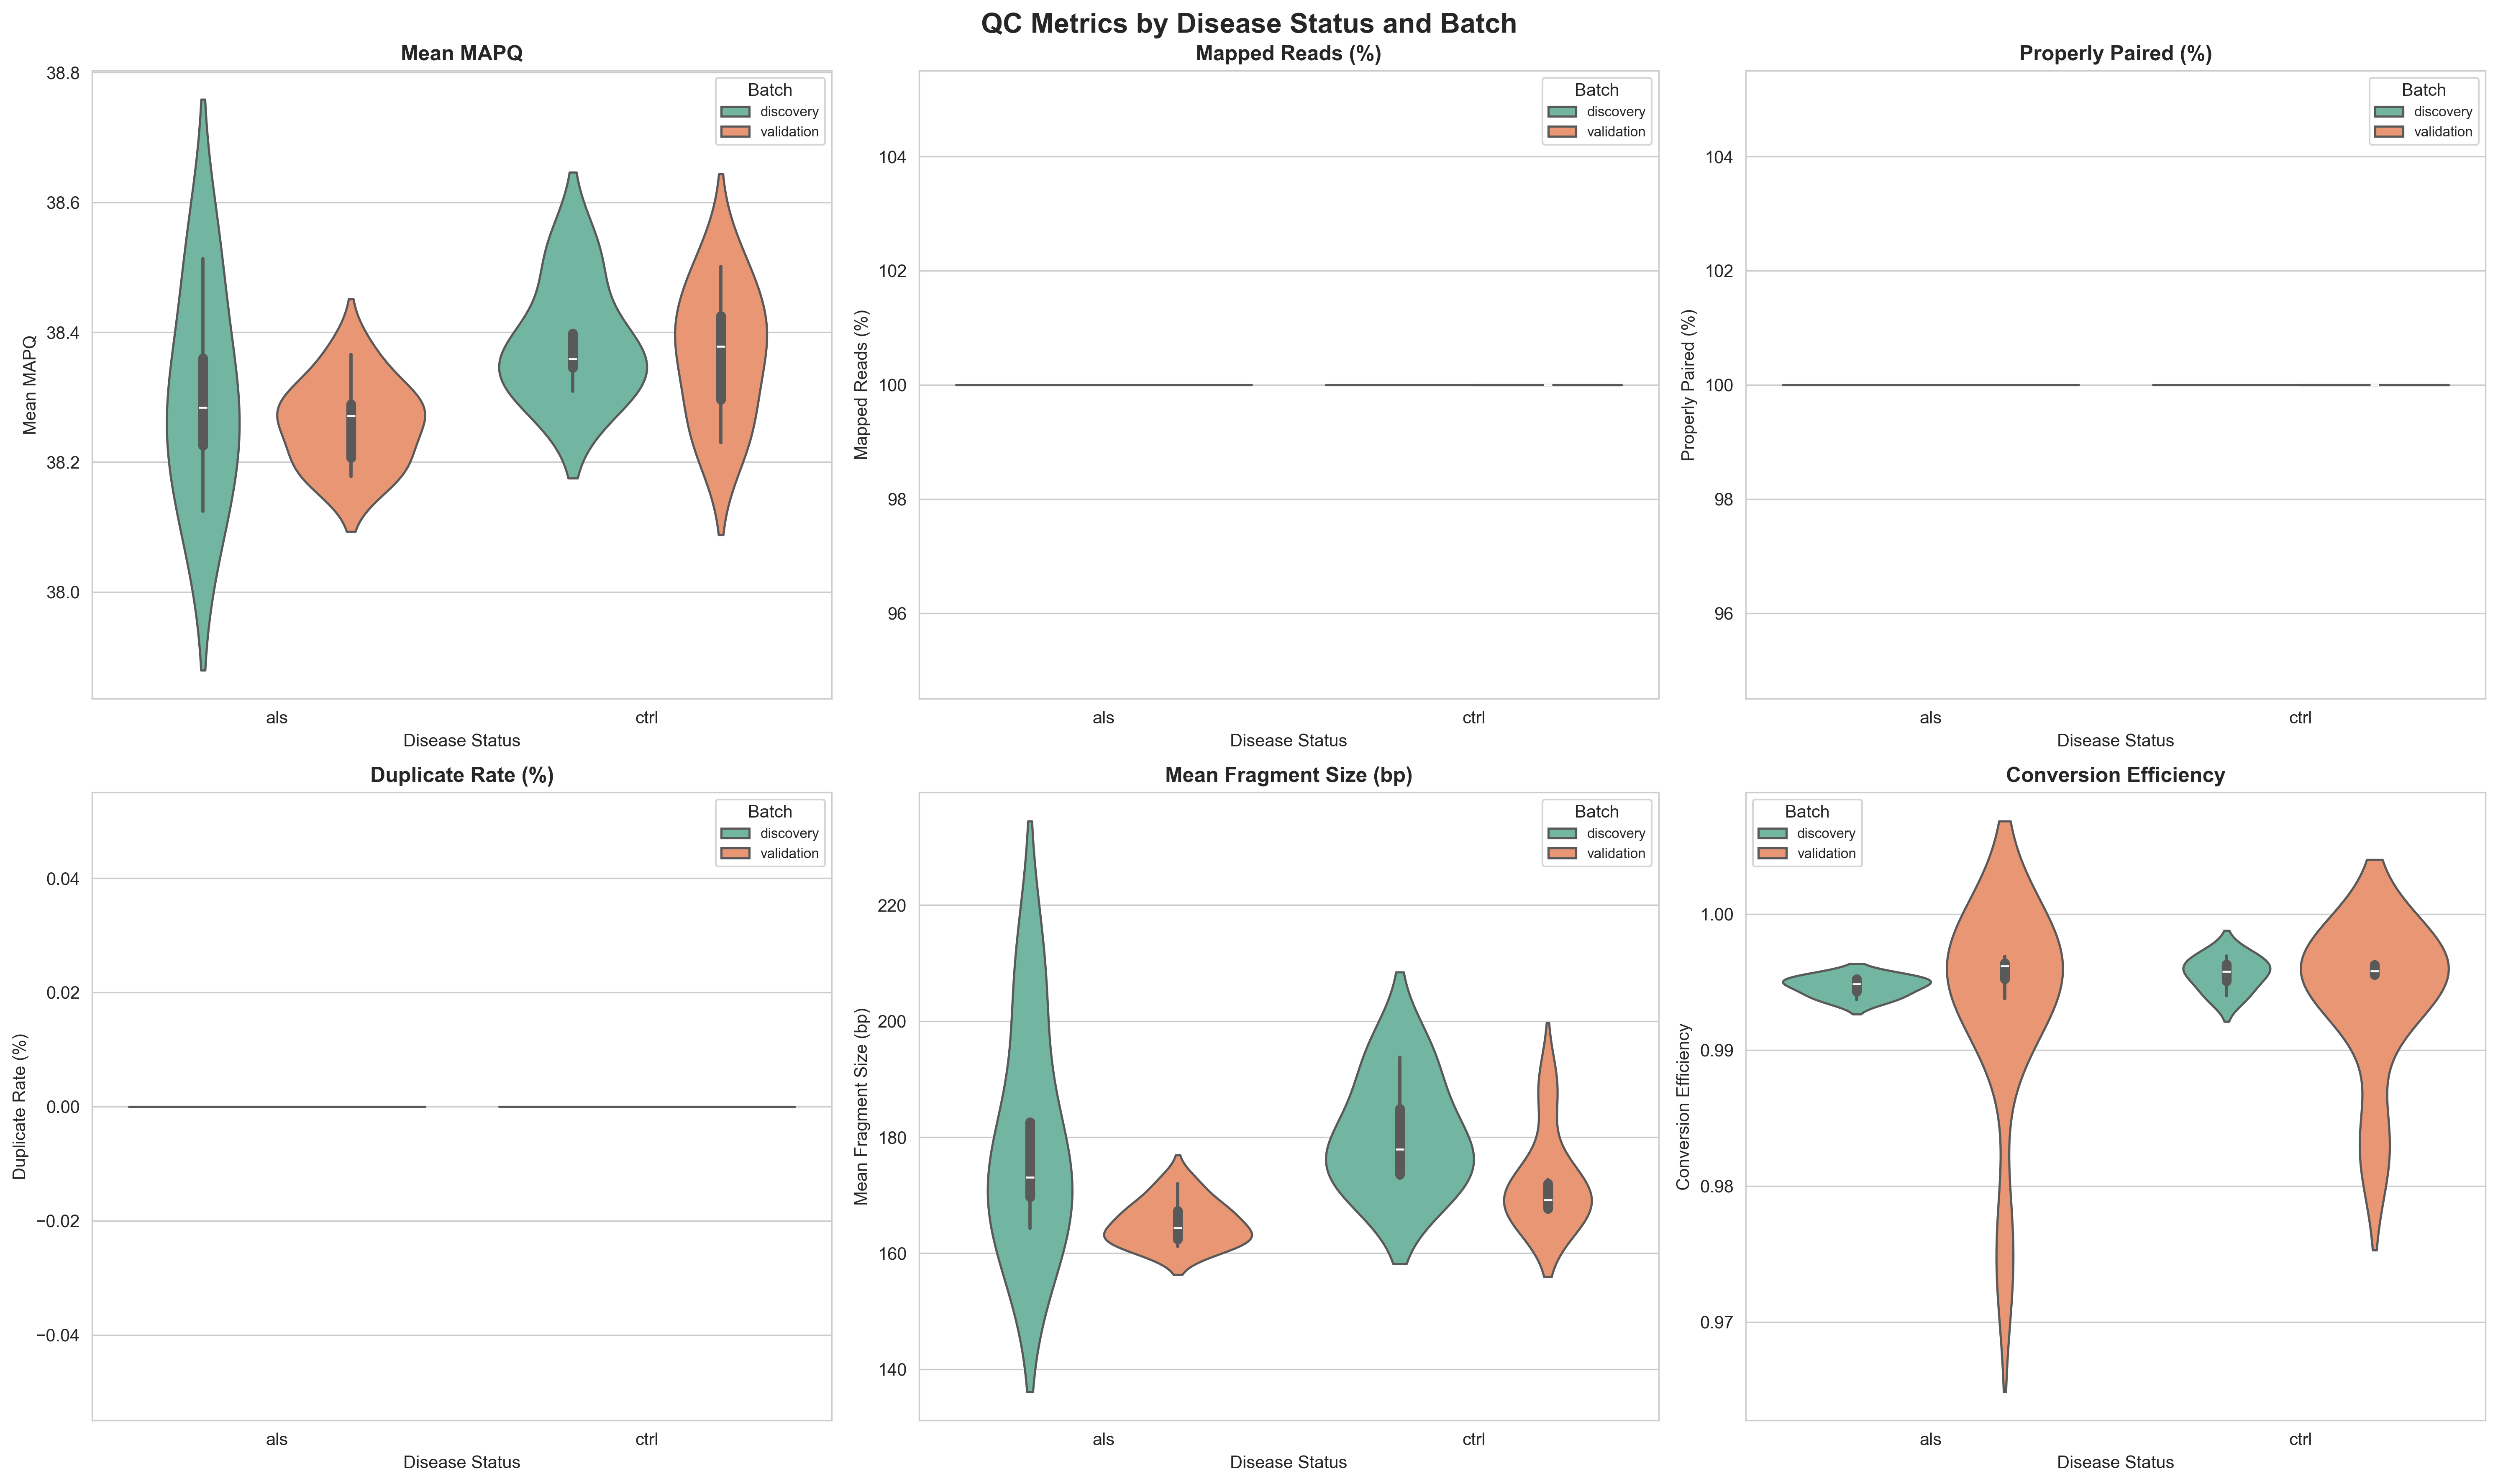

In [7]:
from IPython.display import Image, display

# List all QC plots
qc_plots = list(QC_FIGURES_DIR.glob('*.png'))

print(f"Generated {len(qc_plots)} QC plots:")
for plot in qc_plots:
    print(f"  - {plot.name}")

# Display plots inline
for plot in sorted(qc_plots):
    print(f"\n{plot.name}")
    display(Image(filename=str(plot)))

### View QC Report

Read the text report:

In [8]:
# Read and display QC report
if QC_REPORT.exists():
    with open(QC_REPORT, 'r') as f:
        report = f.read()
    print(report)
else:
    print("QC report not found")

QUALITY CONTROL REPORT

OVERALL SUMMARY
----------------------------------------------------------------------
Total samples: 22
  ALS: 12
  Control: 10
  Discovery batch: 8
  Validation batch: 14

BISULFITE CONVERSION EFFICIENCY
----------------------------------------------------------------------
Mean conversion efficiency: 0.9941 (99.41%)
Minimum conversion efficiency: 0.9748 (97.48%)
Threshold: 0.9900 (99.00%)
Samples below threshold: 2

Samples with poor conversion:
  - SRR13404380: 0.9748
  - SRR13404383: 0.9828

BATCH EFFECT ASSESSMENT
----------------------------------------------------------------------
Metrics with significant batch effects (p < 0.05): 2/8

Significant batch effects:
  - mean_fragment_size: p = 0.0064
  - cpg_methylation_rate: p = 0.0240

QC METRICS SUMMARY STATISTICS
----------------------------------------------------------------------

mean_mapq:
  Mean: 38.32
  Std: 0.11
  Min: 38.12
  Max: 38.51

mapped_pct:
  Mean: 100.00
  Std: 0.00
  Min: 100.00
  Ma

## Option 2: Step-by-Step Execution (Alternative)

If you want to run steps individually instead of using `run_module_1()`:

In [9]:
# Load manifest
manifest = pd.read_csv(SAMPLE_MANIFEST)

# Example: Run QC on just the first sample
first_sample = manifest.iloc[0]
sample_id = first_sample['sample_id']
bam_path = first_sample['bam_path']

print(f"Testing QC on sample: {sample_id}")
print(f"BAM path: {bam_path}")

# Calculate BAM stats
bam_stats = calculate_bam_stats(bam_path, sample_id)
print("\nBAM Statistics:")
for key, value in bam_stats.items():
    if key != 'sample_id':
        print(f"  {key}: {value}")

# Check bisulfite conversion
conv_stats = check_bisulfite_conversion(bam_path, sample_id)
print("\nBisulfite Conversion:")
print(f"  Conversion efficiency: {conv_stats['conversion_efficiency']:.4f} ({conv_stats['conversion_efficiency']*100:.2f}%)")
print(f"  CHH methylation: {conv_stats['chh_methylation_rate']:.4f} ({conv_stats['chh_methylation_rate']*100:.2f}%)")
print(f"  Status: {conv_stats['conversion_flag']}")

Testing QC on sample: SRR13404367
BAM path: /Users/maggiebrown/Desktop/PrimaMente/wgbs_classifier/data/raw/SRR13404367.deduplicated.sorted_ds10mill_chr21.bam

BAM Statistics:
  total_reads: 128966
  mapped_reads: 128966
  mapped_pct: 100.0
  properly_paired: 128966
  properly_paired_pct: 100.0
  duplicates: 0
  duplicate_rate: 0.0
  mean_mapq: 38.12431183412682
  fragment_count: 64476
  mean_fragment_size: 174.68993113716732
  median_fragment_size: 162.0
  std_fragment_size: 56.205029600830855
  min_fragment_size: 51
  max_fragment_size: 983

Bisulfite Conversion:
  Conversion efficiency: 0.9952 (99.52%)
  CHH methylation: 0.0048 (0.48%)
  Status: PASS


## Age vs QC Metrics

Check if age correlates with any QC metrics:

In [10]:
from scipy.stats import spearmanr

# Correlate age with QC metrics
age_correlations = []

for metric in key_metrics:
    if metric in qc_metrics.columns:
        # Remove NaN values
        valid_data = qc_metrics[['age', metric]].dropna()
        
        if len(valid_data) > 2:
            rho, p_value = spearmanr(valid_data['age'], valid_data[metric])
            age_correlations.append({
                'metric': metric,
                'correlation': rho,
                'p_value': p_value,
                'significant': 'Yes' if p_value < 0.05 else 'No'
            })

age_corr_df = pd.DataFrame(age_correlations)
print("Age Correlation with QC Metrics:")
print(age_corr_df.to_string(index=False))

Age Correlation with QC Metrics:
               metric  correlation  p_value significant
            mean_mapq    -0.109132 0.628780          No
           mapped_pct          NaN      NaN          No
  properly_paired_pct          NaN      NaN          No
       duplicate_rate          NaN      NaN          No
   mean_fragment_size    -0.089907 0.690710          No
conversion_efficiency     0.370936 0.089218          No
 cpg_methylation_rate    -0.131750 0.558918          No


## Deep Dive: Batch Effects & Confounding

Based on the QC report, we found:
- 2 samples with conversion < 99%
- Significant batch effects on fragment size (p=0.0064)
- Significant batch effects on CpG methylation (p=0.024)

Investigate further:

### Assess Batch × Disease Status distribution

In [17]:
# Check if batch is confounded with disease status
print("=" * 70)
print("BATCH × DISEASE STATUS DISTRIBUTION")
print("=" * 70)

# Cross-tabulation
contingency = pd.crosstab(qc_metrics['disease_status'], qc_metrics['batch'], margins=True)
print("\nSample counts:")
print(contingency)

# Chi-square test for independence
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(contingency.iloc[:-1, :-1])

print(f"\nChi-square test for independence:")
print(f"  Chi2 statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\n WARNING: Batch is significantly associated with disease status!")
    print("   This means batch and disease are confounded.")
else:
    print("\n✓ Batch is independent of disease status (no confounding)")

# Show percentages
print("\nPercentage distribution:")
pct_table = pd.crosstab(qc_metrics['disease_status'], qc_metrics['batch'], 
                        normalize='columns') * 100
print(pct_table.round(1))

BATCH × DISEASE STATUS DISTRIBUTION

Sample counts:
batch           discovery  validation  All
disease_status                            
als                     4           8   12
ctrl                    4           6   10
All                     8          14   22

Chi-square test for independence:
  Chi2 statistic: 0.0000
  p-value: 1.0000
  Degrees of freedom: 1

✓ Batch is independent of disease status (no confounding)

Percentage distribution:
batch           discovery  validation
disease_status                       
als                  50.0        57.1
ctrl                 50.0        42.9


### Assess fragment size batch effect

In [18]:
print("\n" + "=" * 70)
print("FRAGMENT SIZE BATCH EFFECT")
print("=" * 70)

# Summary by batch
print("\nFragment size by batch:")
frag_summary = qc_metrics.groupby('batch')['mean_fragment_size'].describe()
print(frag_summary)

# Calculate difference
disc_frag = qc_metrics[qc_metrics['batch'] == 'discovery']['mean_fragment_size'].mean()
val_frag = qc_metrics[qc_metrics['batch'] == 'validation']['mean_fragment_size'].mean()
diff = abs(disc_frag - val_frag)

print(f"\nMean fragment size:")
print(f"  Discovery: {disc_frag:.2f} bp")
print(f"  Validation: {val_frag:.2f} bp")
print(f"  Difference: {diff:.2f} bp ({diff/disc_frag*100:.1f}%)")

# Mann-Whitney test
from scipy.stats import mannwhitneyu
disc_sizes = qc_metrics[qc_metrics['batch'] == 'discovery']['mean_fragment_size']
val_sizes = qc_metrics[qc_metrics['batch'] == 'validation']['mean_fragment_size']
stat, p_val = mannwhitneyu(disc_sizes, val_sizes)
print(f"  p-value: {p_val:.4f}")

# Check if disease has similar effect
print("\nFragment size by disease status:")
als_frag = qc_metrics[qc_metrics['disease_status'] == 'als']['mean_fragment_size'].mean()
ctrl_frag = qc_metrics[qc_metrics['disease_status'] == 'ctrl']['mean_fragment_size'].mean()
disease_diff = abs(als_frag - ctrl_frag)

print(f"  ALS: {als_frag:.2f} bp")
print(f"  Control: {ctrl_frag:.2f} bp")
print(f"  Difference: {disease_diff:.2f} bp ({disease_diff/als_frag*100:.1f}%)")

als_sizes = qc_metrics[qc_metrics['disease_status'] == 'als']['mean_fragment_size']
ctrl_sizes = qc_metrics[qc_metrics['disease_status'] == 'ctrl']['mean_fragment_size']
stat, p_val = mannwhitneyu(als_sizes, ctrl_sizes)
print(f"  p-value: {p_val:.4f}")

# Interpretation
print("\nInterpretation:")
if diff > disease_diff:
    print("  Discovery/Validation Batch effect on fragment size is LARGER than disease effect")
    print("  → Split strategy is critical")
else:
    print("  ✓ Disease effect on fragment size is larger than batch effect")


FRAGMENT SIZE BATCH EFFECT

Fragment size by batch:
            count        mean        std         min         25%         50%  \
batch                                                                          
discovery     8.0  179.906123  13.742784  164.272902  172.530396  174.267886   
validation   14.0  168.281900   6.794620  161.219704  163.735454  167.337652   

                   75%         max  
batch                               
discovery   184.938446  206.298381  
validation  169.547249  188.382597  

Mean fragment size:
  Discovery: 179.91 bp
  Validation: 168.28 bp
  Difference: 11.62 bp (6.5%)
  p-value: 0.0064

Fragment size by disease status:
  ALS: 169.88 bp
  Control: 175.67 bp
  Difference: 5.79 bp (3.4%)
  p-value: 0.0321

Interpretation:
  Discovery/Validation Batch effect on fragment size is LARGER than disease effect
  → Split strategy is critical


### Assess CpG methylation batch effect

In [19]:
print("\n" + "=" * 70)
print("CpG METHYLATION BATCH EFFECT")
print("=" * 70)

# Summary by batch
print("\nCpG methylation by batch:")
cpg_summary = qc_metrics.groupby('batch')['cpg_methylation_rate'].describe()
print(cpg_summary)

# Calculate difference
disc_cpg = qc_metrics[qc_metrics['batch'] == 'discovery']['cpg_methylation_rate'].mean()
val_cpg = qc_metrics[qc_metrics['batch'] == 'validation']['cpg_methylation_rate'].mean()
diff = abs(disc_cpg - val_cpg)

print(f"\nMean CpG methylation rate:")
print(f"  Discovery: {disc_cpg:.4f} ({disc_cpg*100:.2f}%)")
print(f"  Validation: {val_cpg:.4f} ({val_cpg*100:.2f}%)")
print(f"  Difference: {diff:.4f} ({diff*100:.2f} percentage points)")

# Mann-Whitney test
disc_cpg_vals = qc_metrics[qc_metrics['batch'] == 'discovery']['cpg_methylation_rate']
val_cpg_vals = qc_metrics[qc_metrics['batch'] == 'validation']['cpg_methylation_rate']
stat, p_val = mannwhitneyu(disc_cpg_vals, val_cpg_vals)
print(f"  p-value: {p_val:.4f}")

# Check if disease has similar effect
print("\nCpG methylation by disease status:")
als_cpg = qc_metrics[qc_metrics['disease_status'] == 'als']['cpg_methylation_rate'].mean()
ctrl_cpg = qc_metrics[qc_metrics['disease_status'] == 'ctrl']['cpg_methylation_rate'].mean()
disease_diff = abs(als_cpg - ctrl_cpg)

print(f"  ALS: {als_cpg:.4f} ({als_cpg*100:.2f}%)")
print(f"  Control: {ctrl_cpg:.4f} ({ctrl_cpg*100:.2f}%)")
print(f"  Difference: {disease_diff:.4f} ({disease_diff*100:.2f} percentage points)")

als_cpg_vals = qc_metrics[qc_metrics['disease_status'] == 'als']['cpg_methylation_rate']
ctrl_cpg_vals = qc_metrics[qc_metrics['disease_status'] == 'ctrl']['cpg_methylation_rate']
stat, p_val = mannwhitneyu(als_cpg_vals, ctrl_cpg_vals)
print(f"  p-value: {p_val:.4f}")

# Interpretation
print("\nInterpretation:")
if diff > disease_diff:
    print("  Discovery/Validation Batch effect on methylation is LARGER than disease effect")
    print("  → This could mask biological signal")
else:
    print("  ✓ Disease effect on methylation is larger than batch effect")


CpG METHYLATION BATCH EFFECT

CpG methylation by batch:
            count      mean       std       min       25%       50%       75%  \
batch                                                                           
discovery     8.0  0.656934  0.018944  0.631872  0.638989  0.660704  0.670266   
validation   14.0  0.635784  0.022071  0.608673  0.619883  0.632973  0.638735   

                 max  
batch                 
discovery   0.683525  
validation  0.682874  

Mean CpG methylation rate:
  Discovery: 0.6569 (65.69%)
  Validation: 0.6358 (63.58%)
  Difference: 0.0212 (2.12 percentage points)
  p-value: 0.0240

CpG methylation by disease status:
  ALS: 0.6443 (64.43%)
  Control: 0.6425 (64.25%)
  Difference: 0.0019 (0.19 percentage points)
  p-value: 0.9212

Interpretation:
  Discovery/Validation Batch effect on methylation is LARGER than disease effect
  → This could mask biological signal


## Summary & Next Steps

**Module 1 Complete!** ✓

**Key Outputs:**
- QC metrics CSV: `data/processed/qc_metrics.csv`
- QC report: `results/qc_report.txt`  
- QC plots: `results/figures/qc/`

**Filtering Criteria Defined:**
- MAPQ ≥ 20
- Fragment size: 50-1000 bp
- Proper pairs only
- Exclude duplicates

**Note:**
- Discovery/Validation Batch Effects significant for fragment size and methylation; use Discovery/Validation split

**Next:**
- Module 2: Feature Extraction (extract fragment sizes, motifs, methylation)